In [9]:
import numpy as np


def get_slice_parameter(bound: tuple[float, float],
                        m: int,
                        scale: float,
                        eps: float
                        ) -> int:
    return int(scale * np.log(m * bound[1] - bound[0]) / eps)


def get_statistics(X: np.ndarray, quantiles: np.ndarray, estimates: np.ndarray) -> float:
    """
    Compute the maximum rank error and the mean absolute rank error between the true quantiles and the estimated quantiles.
    :param X: data set
    :param quantiles: a list of quantiles (values in [0, 1])
    :param estimates: a list of estimated qth-quantiles (values in X)
    :return: a dictionary with the maximum rank error and the mean absolute rank error
    """
    # sort the data
    X = np.sort(X)
    n = len(X)

    # for each result, get the position of the closest element in the sorted array
    positions = np.searchsorted(X, estimates)
    true_positions = [math.floor(q * n) for q in quantiles]

    # compute the normalized rank error
    rank_errors = np.abs(positions - true_positions)

    # get statistics
    max_rank_error = np.max(rank_errors)
    mean_rank_error = np.mean(rank_errors)
    output = {
        'max_error':  max_rank_error,
        'mean_error': mean_rank_error  # Kaplan et al. uses this
    }
    return output

In [45]:
from our_mechanism import SliceQuantile
import pickle
import math

n = 200_000

with open("../data/gaussian_data_large_bounds.pkl", "rb") as f:
    data_1 = pickle.load(f)
    data_1["data"] = np.random.choice(data_1["data"], n, replace=False)
with open("../data/uniform_data_small_bounds.pkl", "rb") as f:
    data_2 = pickle.load(f)
    data_2["data"] = np.random.choice(data_2["data"], n, replace=False)
with open("../data/mixture_data_large_bounds.pkl", "rb") as f:
    data_3_dict = pickle.load(f)
data_3 = data_3_dict[5]
data_3["data"] = np.random.choice(data_3["data"], n, replace=False)
data_4 = data_3_dict[10]
data_4["data"] = np.random.choice(data_4["data"], n, replace=False)
datas = [data_1, data_2, data_3, data_4]

scale_list = np.linspace(0.01, 10, 100)
m = 100
quantiles = np.linspace(0, 1, m + 2)[1:-1]
num_exp = 10
max_errors = np.zeros((len(scale_list), len(datas), num_exp))
for i, scale in enumerate(scale_list):
    for j, data in enumerate(datas):
        mechanism = SliceQuantile(bound=data["bounds"], n=n, m=m, eps=1., swap=False, split=0.5)
        l = get_slice_parameter(data["bounds"], m, scale, eps=mechanism.eps_em)
        mechanism.l = l

        for k in range(num_exp):
            # Run the mechanism
            estimates = mechanism.approximate_mechanism(data["data"], quantiles, delta=1e-10, verbose=False)
            statistics: dict = get_statistics(data["data"], quantiles, estimates)
            max_errors[i][j][k] = statistics['max_error']

/Users/fabrizioboninsegna/Documents/GitHub/GitHub/DP_CC_quantiles/DP_AQ/single_quantile_algo.py:32: RuntimeWarning: divide by zero encountered in log
  idx_left = racing_sample(np.log(intervals) + (epsilon / (2.0 * sensitivity) * utility))


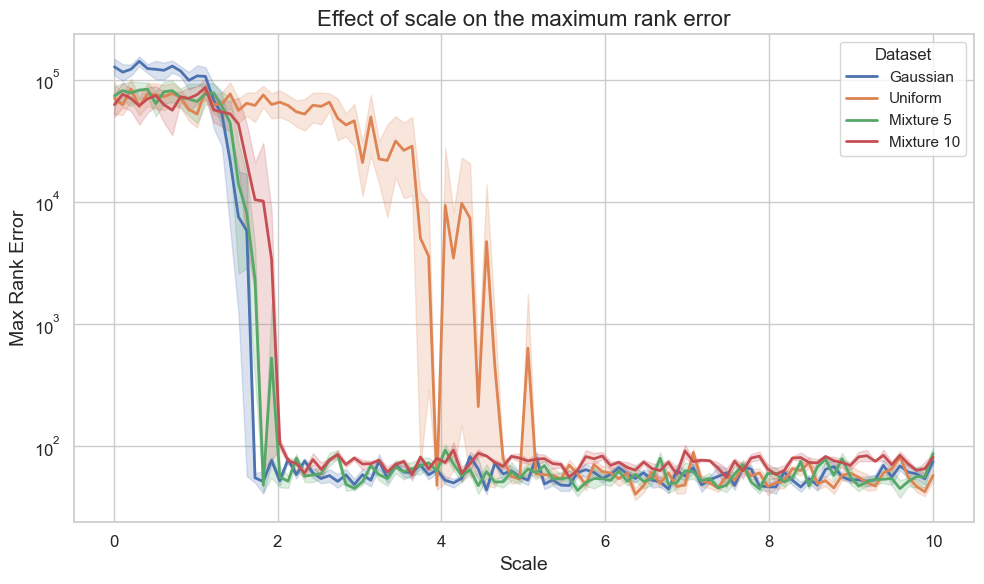

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

records = []
num_exp = 10
for i, scale in enumerate(scale_list):
    for j, data in enumerate(["Gaussian", "Uniform", "Mixture 5", "Mixture 10"]):
        for k in range(num_exp):
            records.append({
                "scale": scale,
                "dataset": data,
                "max_error": max_errors[i][j][k],
            })
df = pd.DataFrame.from_records(records)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Get Seaborn's default palette colors
default_colors = sns.color_palette("deep")

sns.lineplot(
    data=df,
    x="scale",
    y="max_error",
    hue="dataset",
    errorbar=('ci', 95),  # confidence interval 95%
    linewidth=2,
)

plt.title("Effect of scale on the maximum rank error", fontsize=16)
plt.xlabel("Scale", fontsize=14)
plt.ylabel("Max Rank Error", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale("log")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()



,scale,dataset,max_error
0,0.01,Gaussian,131028.0
1,0.01,Gaussian,111734.0
2,0.01,Gaussian,180057.0
3,0.01,Gaussian,110889.0
4,0.01,Gaussian,115992.0
...,...,...,...
3995,10.00,Mixture 10,76.0
3996,10.00,Mixture 10,83.0
3997,10.00,Mixture 10,69.0
3998,10.00,Mixture 10,75.0


In [33]:
records

[]